<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagging - Random Forest

![](https://i.insider.com/5afc8f2c5e48ec47008b4818?width=700)

# Install

In [1]:
!pip install treeinterpreter
!pip install rgf_python 

# Setup

In [2]:
import math
import random
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from rgf import RGFRegressor
from rgf import RGFClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from treeinterpreter import treeinterpreter as ti

from sklearn.tree import export_graphviz

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%matplotlib inline

# Data

In [4]:
boston = load_boston()

In [5]:
boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['TARGET'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
X_boston = boston_df.drop('TARGET', axis=1)
y_boston = boston_df['TARGET']
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(X_boston, y_boston, test_size=0.2)

# Metrics

In [7]:
def regression_metrics(truth, predictions):
    mae  = mean_absolute_error(truth, predictions)
    mse  = mean_squared_error(truth,  predictions)
    rmse = math.sqrt(mse)

    # Print out error for predictions
    print('MAE      : {:.3f}'.format(mae))
    print('MSE      : {:.3f}'.format(mse))
    print('RMSE     : {:.3f}'.format(rmse))

    # Compute Accuracy
    errors = abs(truth - predictions)
    mape = 100 * (errors / truth)
    accuracy = 100 - np.mean(mape)
    print('Accuracy : {:.2f}%'.format(accuracy))
    
    return (mae, mse, rmse, accuracy)

In [8]:
results_regression_df       = pd.DataFrame(columns=['MAE', 'RMSE'])

# Random Forest

![](https://liyanxu.blog/wp-content/uploads/2018/10/Screen-Shot-2018-11-19-at-23.05.00.png)

## Model

In [9]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train_boston, y_train_boston)
print(f'OOB {rf.oob_score_:.4f}')

OOB 0.8508


## Score

In [10]:
pred = rf.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['RandomForest'] = [mae, rmse]

MAE      : 2.255
MSE      : 9.953
RMSE     : 3.155
Accuracy : 88.64%


## Hypertune
* n_estimators
* max_features
* min_samples_split
* min_samples_leaf

In [11]:
n_estimators = [100, 200, 400, 800]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid for feature sealection
random_grid = {'n_estimators'      : n_estimators,
               'max_features'      : max_features,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf'  : min_samples_leaf}

pprint(random_grid)

{'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 800]}


In [12]:
rf_search = RandomForestRegressor()
rf_random_search = RandomizedSearchCV(estimator = rf_search, 
                               param_distributions = random_grid, 
                               n_iter = 300,
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random_search.fit(X_train_boston, y_train_boston)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 72 is smaller than n_iter=300. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [13]:
rf_random_search.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [14]:
rf = RandomForestRegressor(n_estimators  = rf_random_search.best_params_['n_estimators'], 
                           min_samples_split = rf_random_search.best_params_['min_samples_split'],
                           min_samples_leaf  = rf_random_search.best_params_['min_samples_leaf'],
                           max_features      = rf_random_search.best_params_['max_features'],
                           oob_score=True)
rf.fit(X_train_boston, y_train_boston)
print(f'OOB {rf.oob_score_:.4f}')

OOB 0.8745


In [15]:
pred = rf.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['RandomForest Hypertuned'] = [mae, rmse]

MAE      : 2.315
MSE      : 14.258
RMSE     : 3.776
Accuracy : 88.46%


## Residuals

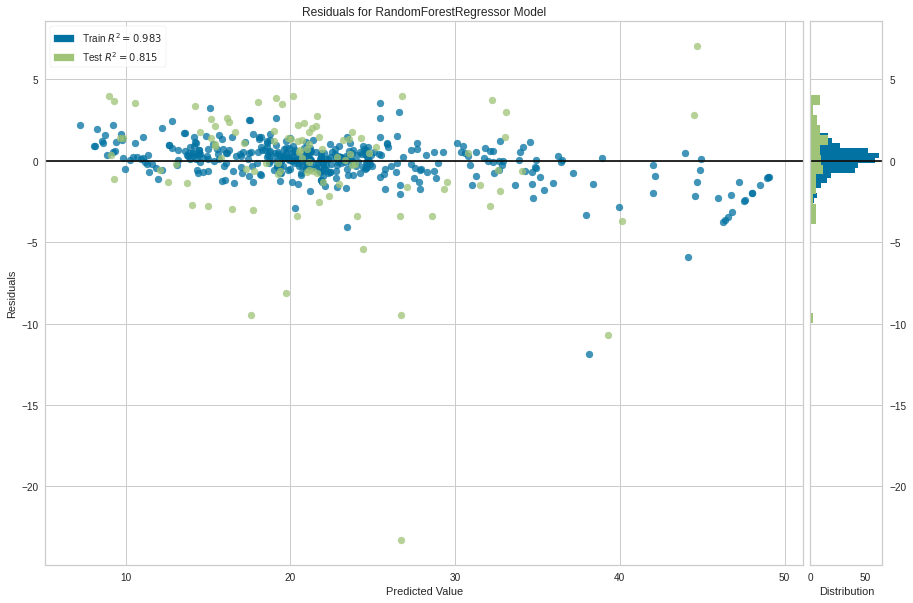

In [16]:
plt.figure(figsize=(15,10))
visualizer = ResidualsPlot(rf)
visualizer.fit(X_train_boston, y_train_boston)  # Fit the training data to the model
visualizer.score(X_test_boston, y_test_boston)  # Evaluate the model on the test data
visualizer.poof() 

## Prediction Error

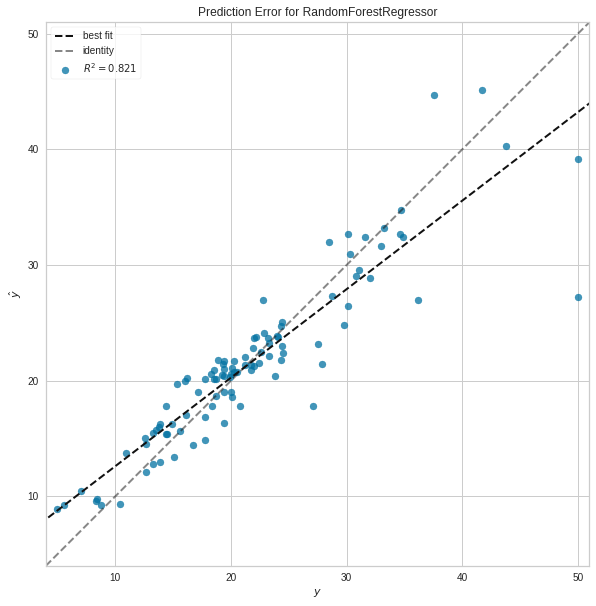

In [17]:
plt.figure(figsize=(15,10))
visualizer = PredictionError(rf)
visualizer.fit(X_train_boston, y_train_boston)  # Fit the training data to the model
visualizer.score(X_test_boston, y_test_boston)  # Evaluate the model on the test data
visualizer.poof() 

## Importance

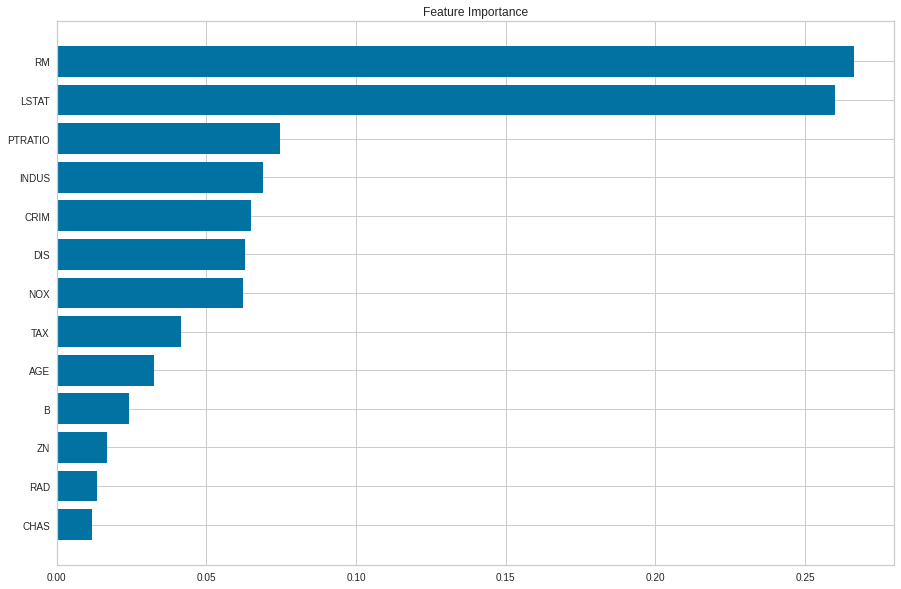

In [18]:
features = X_train_boston.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importance')
plt.barh(range(len(indices)),   importances[indices], color='b')
plt.yticks(range(len(indices)), features[indices])
plt.show()

## Prediction Interval

In [19]:
def interval(model, X, percentile=95):
    pi_down  = []
    pi_up    = []
    model_preds = []
    
    for est in model.estimators_:
        predictions = est.predict(X)
        model_preds.append(predictions)
        
    for pt in range(len(X)):
        predicted = []
        for mp in range(len(model_preds)):
            predicted.append(model_preds[mp][pt])
        pi_down.append(np.percentile(predicted, q=(100-percentile) / 2.))
        pi_up.append(np.percentile(predicted, q=100-(100-percentile) / 2.)) 
    return pi_down, pi_up

# Generate the Intervals
interval_y = y_test_boston.copy().reset_index(drop=True)
interval_x = X_test_boston.copy().reset_index(drop=True)
interval_pred = rf.predict(interval_x)

percentile = 95
err_down, err_up = interval(rf, interval_x, percentile=percentile)
pi_df = pd.DataFrame({'Predicted': interval_pred, 
                     'Lower': err_down, 
                     'Actual': interval_y, 
                     'Upper': err_up})
pi_df['Correct'] = np.where((pi_df.Lower <= pi_df.Actual) & (pi_df.Actual <= pi_df.Upper), 1, 0)
print('Percent in {}th prediction interval: {:.3f}'.format(percentile, 
                                                           pi_df.Correct.sum() / pi_df.Correct.shape[0] * 100.0))

Percent in 95th prediction interval: 95.098


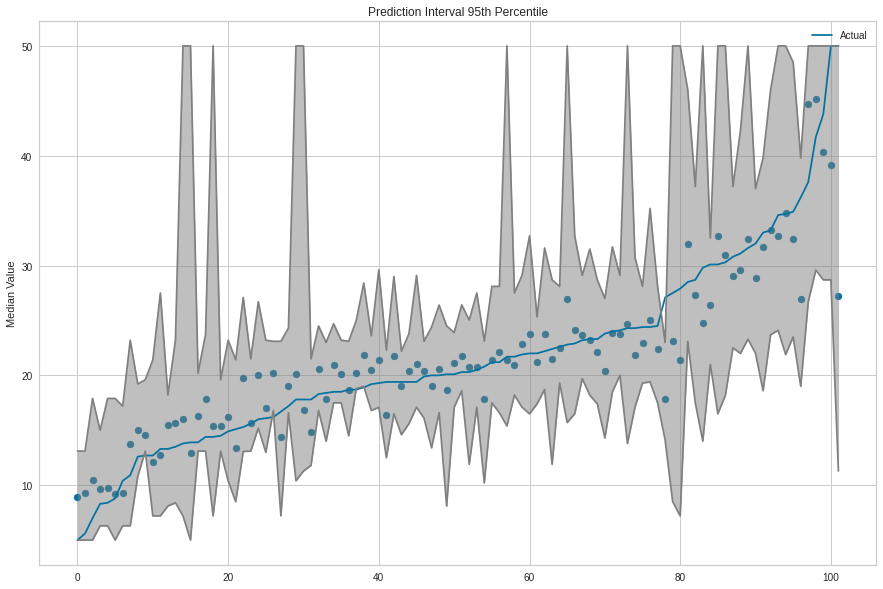

In [20]:
df = pi_df.sort_values('Actual').reset_index()
plt.figure(figsize=(15,10))
plt.title('Prediction Interval {}th Percentile'.format(percentile))
plt.ylabel('Median Value')
plt.plot(df.Actual, label='Actual')
plt.plot(df.Lower, color='grey')
plt.plot(df.Upper, color='grey')
plt.scatter(df.index, df.Predicted)
plt.fill_between(df.index, df.Lower, df.Upper, color='grey', alpha=0.5)
plt.legend()
plt.show()

## Contribution

In [21]:
prediction, bias, contributions = ti.predict(rf, X_test_boston)
contribDF = pd.DataFrame({'Feature': X_test_boston.columns, 
                          'Contribution': contributions[0],
                          'Value':X_test_boston.iloc[0]})
contribDF = contribDF.sort_values('Contribution').set_index('Feature')

print('Baseline (Y-Mean) / Bias of RF : {:.2f}\n'.format(bias[0]))
print(contribDF)
print('\nSum of Contribution {:.2f}\n'.format(contribDF.Contribution.sum()))
print('Predicted Value of RF : {:.2f}'.format(*prediction[0]))
print('Predicted Value of RF : {:.2f} = Bias {:.2f} + Contribution {:.2f}'.format(
    *prediction[0], bias[0], contribDF.Contribution.sum()))

Baseline (Y-Mean) / Bias of RF : 22.76

         Contribution      Value
Feature                         
RM          -2.506517    5.78600
LSTAT       -1.871270   14.15000
INDUS       -0.479325    6.91000
ZN          -0.180184    0.00000
CHAS        -0.056983    0.00000
RAD         -0.052347    3.00000
B            0.107432  396.90000
DIS          0.167865    5.10040
CRIM         0.354261    0.18836
AGE          0.529837   33.30000
NOX          0.570652    0.44800
PTRATIO      0.627618   17.90000
TAX          0.635307  233.00000

Sum of Contribution -2.15

Predicted Value of RF : 20.61
Predicted Value of RF : 20.61 = Bias 22.76 + Contribution -2.15


# Extra Trees

![](https://miro.medium.com/max/743/1*03-fhHP6Wi63VkmY9PqChA.jpeg)

## Model

In [22]:
et = ExtraTreesRegressor(bootstrap=True, oob_score=True)
et.fit(X_train_boston,  y_train_boston)
print(f'OOB {rf.oob_score_:.4f}')

OOB 0.8681


## Score

In [23]:
pred = et.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['ExtraTrees'] = [mae, rmse]

MAE      : 2.187
MSE      : 14.211
RMSE     : 3.770
Accuracy : 89.30%


## Hypertune

In [24]:
n_estimators = [100, 200, 400, 800]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Create the random grid for feature sealection
random_grid = {'n_estimators'      : n_estimators,
               'max_features'      : max_features,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf'  : min_samples_leaf}

pprint(random_grid)

{'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 800]}


In [25]:
et_search = ExtraTreesRegressor()
et_random_search = RandomizedSearchCV(estimator = et_search, 
                               param_distributions = random_grid, 
                               n_iter = 300,
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
et_random_search.fit(X_train_boston, y_train_boston)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 72 is smaller than n_iter=300. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                      

In [26]:
et_random_search.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [27]:
et = ExtraTreesRegressor(n_estimators  = et_random_search.best_params_['n_estimators'], 
                           min_samples_split = et_random_search.best_params_['min_samples_split'],
                           min_samples_leaf  = et_random_search.best_params_['min_samples_leaf'],
                           max_features      = et_random_search.best_params_['max_features'],
                           bootstrap=True, oob_score=True)
et.fit(X_train_boston, y_train_boston)
print(f'OOB {et.oob_score_:.4f}')

OOB 0.8802


In [28]:
pred = et.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['ExtraTrees Hypertuned'] = [mae, rmse]

MAE      : 2.276
MSE      : 14.995
RMSE     : 3.872
Accuracy : 88.84%


## Importance

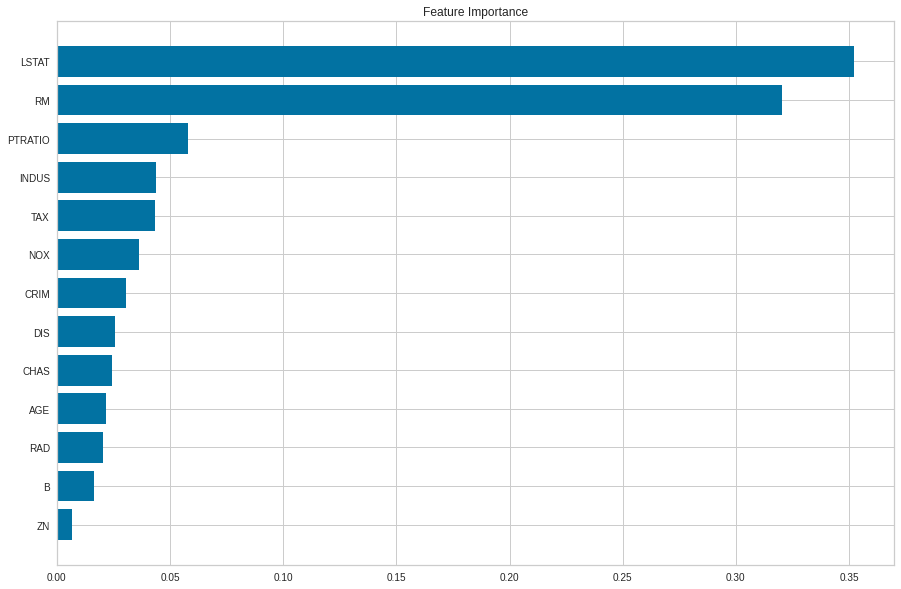

In [29]:
features = X_train_boston.columns
importances = et.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importance')
plt.barh(range(len(indices)),   importances[indices], color='b')
plt.yticks(range(len(indices)), features[indices])
plt.show()

# Regularized Greedy Forest
* https://github.com/RGF-team/rgf/tree/master/python-package
* https://arxiv.org/abs/1109.0887

![](https://csdl-images.computer.org/trans/tp/2014/05/figures/johns11-159.gif)

## Model

In [30]:
rgf = RGFRegressor()
rgf.fit(X_train_boston,  y_train_boston)

RGFRegressor(algorithm='RGF', init_model=None, l2=0.1, learning_rate=0.5,
             loss='LS', max_leaf=500, memory_policy='generous',
             min_samples_leaf=10, n_iter=None, n_tree_search=1, normalize=True,
             opt_interval=100, reg_depth=1.0, sl2=None, test_interval=100,
             verbose=0)

## Score

In [31]:
pred = rgf.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['RegularizedGreedyForest'] = [mae, rmse]

MAE      : 2.182
MSE      : 9.570
RMSE     : 3.093
Accuracy : 89.64%


## Hypertune

In [32]:
algorithm = ['RGF', 'RGF_Opt', 'RGF_Sib']
max_leaf = [250, 500, 750, 1000]
l2 = [0.01, 0.1, 1.0]
learning_rate = [0.1, 0.25, 0.5, 0.75, 1.0]

# Create the random grid for feature sealection
random_grid = {'algorithm'     : algorithm,
               'max_leaf'      : max_leaf,
               'l2'            : l2,
               'learning_rate' : learning_rate}

pprint(random_grid)

{'algorithm': ['RGF', 'RGF_Opt', 'RGF_Sib'],
 'l2': [0.01, 0.1, 1.0],
 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0],
 'max_leaf': [250, 500, 750, 1000]}


In [33]:
rgf_search = RGFRegressor(test_interval=100, loss="LS", verbose=False)
rgf_random_search = RandomizedSearchCV(estimator = rgf_search, 
                               param_distributions = random_grid, 
                               n_iter = 300,
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rgf_random_search.fit(X_train_boston,  y_train_boston)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 180 is smaller than n_iter=300. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RGFRegressor(algorithm='RGF', init_model=None,
                                          l2=0.1, learning_rate=0.5, loss='LS',
                                          max_leaf=500,
                                          memory_policy='generous',
                                          min_samples_leaf=10, n_iter=None,
                                          n_tree_search=1, normalize=True,
                                          opt_interval=100, reg_depth=1.0,
                                          sl2=None, test_interval=100,
                                          verbose=False),
                   iid='deprecated', n_iter=300, n_jobs=-1,
                   param_distributions={'algorithm': ['RGF', 'RGF_Opt',
                                                      'RGF_Sib'],
                                        'l2': [0.01, 0.1, 1.0],
                                        'learning_rate': [

In [34]:
rgf_random_search.best_params_

{'algorithm': 'RGF_Sib', 'l2': 0.1, 'learning_rate': 1.0, 'max_leaf': 1000}

In [35]:
rgf = RGFRegressor(test_interval=100, 
                   loss="LS", 
                   verbose=False,
                   max_leaf      = rgf_random_search.best_params_['max_leaf'],
                   learning_rate = rgf_random_search.best_params_['learning_rate'],
                   algorithm     = rgf_random_search.best_params_['algorithm'],
                   l2            = rgf_random_search.best_params_['l2'])
rgf.fit(X_train_boston,  y_train_boston)

RGFRegressor(algorithm='RGF_Sib', init_model=None, l2=0.1, learning_rate=1.0,
             loss='LS', max_leaf=1000, memory_policy='generous',
             min_samples_leaf=10, n_iter=None, n_tree_search=1, normalize=True,
             opt_interval=100, reg_depth=1.0, sl2=None, test_interval=100,
             verbose=False)

In [36]:
pred = rgf.predict(X_test_boston)
mae, mse, rmse, _ = regression_metrics(y_test_boston, pred)
results_regression_df.loc['RegularizedGreedyForest Hypertuned'] = [mae, rmse]

MAE      : 2.181
MSE      : 10.180
RMSE     : 3.191
Accuracy : 89.50%


## Importance

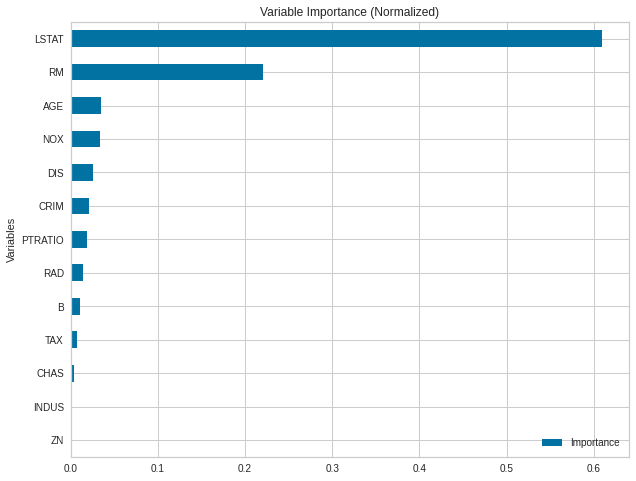

In [37]:
imp_df = pd.DataFrame({'Variables': X_train_boston.columns, 'Importance': rgf.feature_importances_})
imp_df.set_index('Variables').sort_values('Importance', ascending=True).plot.barh(figsize=(10,8))
plt.title('Variable Importance (Normalized)')
plt.legend(loc='lower right')

# Comparison

## MAE

In [38]:
results_regression_df.sort_values('MAE')

,MAE,RMSE
RegularizedGreedyForest Hypertuned,2.180637,3.190544
RegularizedGreedyForest,2.181759,3.093499
ExtraTrees,2.187275,3.769798
RandomForest,2.255275,3.154903
ExtraTrees Hypertuned,2.276426,3.872382
RandomForest Hypertuned,2.315400,3.775996


## RMSE

In [39]:
results_regression_df.sort_values('RMSE')

,MAE,RMSE
RegularizedGreedyForest,2.181759,3.093499
RandomForest,2.255275,3.154903
RegularizedGreedyForest Hypertuned,2.180637,3.190544
ExtraTrees,2.187275,3.769798
RandomForest Hypertuned,2.315400,3.775996
ExtraTrees Hypertuned,2.276426,3.872382


# Practical Advice & Tips
* https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/
* Random Forests
  * Work by reducing variance of individual trees.
  * Experience decreasing accuracy when the number of unrelated features is increased
  * Boosting is usually always slightly better than Random Forest (Switch to XGBoost, LightGBM or CatBoost)
  * Can train trees in parallel
* Regularized Greedy Forests > Extra Trees > Random Forests
  * Extra Trees are roughly 2-3X faster at training
  * Extra Trees is more robust to unrelated features compared to Random Forest
  * RGF and fastRGF can outperform both RF and ET (on par with Gradient Boosting)
* Parameter Tuning
  * Keep max_depth=None and set min_samples_leaf instead. 
  * Controlling the depth of a tree can only increase the performance marginally and it’s not worth having to grid-search over an extra parameter.
  * Keep the number of trees, n_estimators high. RFs don’t overfit when this parameter is increased.
  * Optimising over max_features should be beneficial.
* Cross-validation 
  * Not strictly necessary 
  * Bootstrapping can use out-of-bag errors instead enabling cross-validation and fitting in one go. 
  * CV errors are very close to OOB errors, so use oob_score=True.
* Don’t bother with proximity plots for classification trees.
